In [2]:
import pandas as pd
import tqdm.auto as tqdm

def read_csv_file(user_id, video_id):
    filepath = f'./Experiment_1/{user_id}/video_{video_id}.csv'
    df = pd.read_csv(filepath)
    df['video_id'] = video_id  # 添加video_id字段
    return df

data_with_labels = []

for user_id in range(1, 49):
    user_data = []
    for video_id in range(0, 9):
        df = read_csv_file(user_id, video_id)

        # 对数据进行预处理，例如计算每秒的坐标等
        # df = preprocess(df)
 
        # 添加标签（用户ID）
        df['user_id'] = user_id

        user_data.append(df)

    user_data_combined = pd.concat(user_data, ignore_index=True)
    data_with_labels.append(user_data_combined)

data_with_labels = pd.concat(data_with_labels, ignore_index=True)


In [3]:
from datetime import timedelta
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
from keras.layers import Reshape
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.utils import to_categorical

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        q = tf.nn.tanh(tf.linalg.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(tf.reduce_sum(q * x, axis=-1), axis=-1)
        return tf.reduce_sum(a[:, :, tf.newaxis] * x, axis=1)

def process_data(data, i):
    data.loc[:, 'Timestamp'] = pd.to_datetime(data.loc[:, 'Timestamp'])
    data.loc[:, 'rounded_time'] = pd.to_datetime(data.loc[:, 'Timestamp']).dt.floor('100ms')

    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    print("Processing",i)
    for user_id, user_data in tqdm(data.groupby('user_id')):
        for video_id, video_data in user_data.groupby('video_id'):
            for second, second_data in video_data.groupby(video_data['rounded_time'].dt.floor('1s')):
                time_slices = []
                for _, chunk_data in second_data.groupby(pd.cut(pd.to_datetime(second_data['Timestamp']), pd.date_range(second, second + timedelta(seconds=1), periods=11)), observed = True):
                    if not chunk_data.empty:
                        chunk_data = chunk_data[['UnitQuaternion.x', 'UnitQuaternion.y', 'UnitQuaternion.z', 'UnitQuaternion.w', 'HmdPosition.x', 'HmdPosition.y', 'HmdPosition.z']]
                        time_slices.append(chunk_data.mean().values)

                if len(time_slices) == 10:
                    if video_id == i:
                        test_data.append(time_slices)
                        test_labels.append(user_id)
                    else:
                        train_data.append(time_slices)
                        train_labels.append(user_id)

    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)

# Load your data_with_labels dataframe here
# data_with_labels = pd.DataFrame(...)

# Define the path to save the models
model_path = './model_{}.tflite'

for i in range(9):
    train_data, train_labels, test_data, test_labels = process_data(data_with_labels, i)

    # Convert user IDs to integers
    unique_labels = np.unique(np.concatenate([train_labels, test_labels]))
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    int_train_labels = np.array([label_map[label] for label in train_labels])
    int_test_labels = np.array([label_map[label] for label in test_labels])

    # Convert label data to one-hot encoding
    one_hot_train_labels = to_categorical(int_train_labels, num_classes=len(unique_labels))
    one_hot_test_labels = to_categorical(int_test_labels, num_classes=len(unique_labels))

    # Train the model
    #with tf.device('/device:GPU:0'):
    # Define the model
    model = Sequential()
    model.add(Bidirectional(LSTM(128, input_shape=(10, 7), return_sequences=True)))
    model.add(AttentionLayer())
    model.add(Reshape((1, -1)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(len(unique_labels), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Reshape the training and testing data
    train_data = train_data.reshape(train_data.shape[0], 10, 7)
    test_data = test_data.reshape(test_data.shape[0], 10, 7)

    # Train the model
    batch_size = min(128, train_data.shape[0])
    model.fit(train_data, one_hot_train_labels, epochs=50, batch_size=batch_size, validation_data=(test_data, one_hot_test_labels))

    # Save the model to a file
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    tflite_model = converter.convert()

    # Save the model.
    with open(model_path.format(i), 'wb') as f:
        f.write(tflite_model)
    print(f"Model {i} saved to {model_path.format(i)}")


Processing 0


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 22:19:21.726601: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-10-14 22:19:21.726622: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-14 22:19:21.726630: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-14 22:19:21.726658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 22:19:21.726672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 22:19:23.462511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-10-14 22:19:23.599799

917/917 [==============================] - ETA: 0s - loss: 1.6794 - accuracy: 0.4307

2023-10-14 22:19:46.750066: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


917/917 [==============================] - 26s 26ms/step - loss: 1.6794 - accuracy: 0.4307 - val_loss: 1.7085 - val_accuracy: 0.4186
Epoch 2/50
917/917 [==============================] - 23s 25ms/step - loss: 1.1274 - accuracy: 0.6037 - val_loss: 1.5637 - val_accuracy: 0.4755
Epoch 3/50
917/917 [==============================] - 23s 25ms/step - loss: 0.8658 - accuracy: 0.7056 - val_loss: 1.3695 - val_accuracy: 0.5721
Epoch 4/50
917/917 [==============================] - 23s 25ms/step - loss: 0.6498 - accuracy: 0.7849 - val_loss: 1.2379 - val_accuracy: 0.6271
Epoch 5/50
917/917 [==============================] - 23s 25ms/step - loss: 0.5153 - accuracy: 0.8285 - val_loss: 1.0544 - val_accuracy: 0.6835
Epoch 6/50
917/917 [==============================] - 23s 25ms/step - loss: 0.4378 - accuracy: 0.8531 - val_loss: 1.0718 - val_accuracy: 0.7080
Epoch 7/50
917/917 [==============================] - 23s 25ms/step - loss: 0.3828 - accuracy: 0.8724 - val_loss: 1.1514 - val_accuracy: 0.6843
Epo

2023-10-14 22:38:59.251802: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 22:38:59.251859: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 22:38:59.252002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 22:38:59.252013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 22:38:59.397331: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 22:38:59.397346: W tensorflow/compiler/m

Model 0 saved to ./model_0.tflite
Processing 1


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 22:46:20.534478: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


903/903 [==============================] - ETA: 0s - loss: 1.6927 - accuracy: 0.4383

2023-10-14 22:46:45.666432: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


903/903 [==============================] - 28s 28ms/step - loss: 1.6927 - accuracy: 0.4383 - val_loss: 1.2909 - val_accuracy: 0.5194
Epoch 2/50
903/903 [==============================] - 24s 26ms/step - loss: 1.0192 - accuracy: 0.6546 - val_loss: 1.0329 - val_accuracy: 0.6357
Epoch 3/50
903/903 [==============================] - 23s 26ms/step - loss: 0.6883 - accuracy: 0.7737 - val_loss: 0.7482 - val_accuracy: 0.7328
Epoch 4/50
903/903 [==============================] - 24s 27ms/step - loss: 0.5573 - accuracy: 0.8143 - val_loss: 0.7766 - val_accuracy: 0.7098
Epoch 5/50
903/903 [==============================] - 24s 27ms/step - loss: 0.4754 - accuracy: 0.8423 - val_loss: 0.7378 - val_accuracy: 0.7478
Epoch 6/50
903/903 [==============================] - 23s 25ms/step - loss: 0.4282 - accuracy: 0.8564 - val_loss: 1.0400 - val_accuracy: 0.6420
Epoch 7/50
903/903 [==============================] - 23s 25ms/step - loss: 0.3959 - accuracy: 0.8680 - val_loss: 0.7068 - val_accuracy: 0.7461
Epo

2023-10-14 23:06:09.751485: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 23:06:09.751545: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 23:06:09.751667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 23:06:09.751680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 23:06:09.892570: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 23:06:09.892586: W tensorflow/compiler/m

Model 1 saved to ./model_1.tflite
Processing 2


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 23:13:25.039334: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


869/869 [==============================] - ETA: 0s - loss: 1.7108 - accuracy: 0.4297

2023-10-14 23:13:48.582440: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


869/869 [==============================] - 27s 28ms/step - loss: 1.7108 - accuracy: 0.4297 - val_loss: 1.5054 - val_accuracy: 0.4688
Epoch 2/50
869/869 [==============================] - 24s 27ms/step - loss: 1.1502 - accuracy: 0.5980 - val_loss: 1.3605 - val_accuracy: 0.5265
Epoch 3/50
869/869 [==============================] - 24s 27ms/step - loss: 0.9400 - accuracy: 0.6799 - val_loss: 1.2507 - val_accuracy: 0.5660
Epoch 4/50
869/869 [==============================] - 24s 27ms/step - loss: 0.7268 - accuracy: 0.7605 - val_loss: 1.0245 - val_accuracy: 0.6452
Epoch 5/50
869/869 [==============================] - 24s 27ms/step - loss: 0.5758 - accuracy: 0.8106 - val_loss: 1.0060 - val_accuracy: 0.6711
Epoch 6/50
869/869 [==============================] - 24s 28ms/step - loss: 0.4910 - accuracy: 0.8376 - val_loss: 0.9762 - val_accuracy: 0.6576
Epoch 7/50
869/869 [==============================] - 24s 28ms/step - loss: 0.4237 - accuracy: 0.8596 - val_loss: 0.8645 - val_accuracy: 0.7211
Epo

2023-10-14 23:33:40.102643: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 23:33:40.102726: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 23:33:40.102847: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 23:33:40.102860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 23:33:40.247544: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 23:33:40.247562: W tensorflow/compiler/m

Model 2 saved to ./model_2.tflite
Processing 3


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 23:40:54.055581: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


914/914 [==============================] - ETA: 0s - loss: 1.6846 - accuracy: 0.4361

2023-10-14 23:41:20.007803: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


914/914 [==============================] - 29s 29ms/step - loss: 1.6846 - accuracy: 0.4361 - val_loss: 1.0939 - val_accuracy: 0.6044
Epoch 2/50
914/914 [==============================] - 25s 27ms/step - loss: 1.1386 - accuracy: 0.6042 - val_loss: 0.9747 - val_accuracy: 0.6694
Epoch 3/50
914/914 [==============================] - 25s 27ms/step - loss: 0.8750 - accuracy: 0.7029 - val_loss: 0.7613 - val_accuracy: 0.7785
Epoch 4/50
914/914 [==============================] - 25s 27ms/step - loss: 0.6554 - accuracy: 0.7829 - val_loss: 0.5539 - val_accuracy: 0.8357
Epoch 5/50
914/914 [==============================] - 25s 27ms/step - loss: 0.5240 - accuracy: 0.8266 - val_loss: 0.5022 - val_accuracy: 0.8387
Epoch 6/50
914/914 [==============================] - 25s 27ms/step - loss: 0.4564 - accuracy: 0.8463 - val_loss: 0.4808 - val_accuracy: 0.8455
Epoch 7/50
914/914 [==============================] - 25s 27ms/step - loss: 0.4009 - accuracy: 0.8653 - val_loss: 0.4064 - val_accuracy: 0.8703
Epo

2023-10-15 00:01:53.200196: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-15 00:01:53.200266: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-15 00:01:53.200391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-15 00:01:53.200402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-15 00:01:53.345240: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-15 00:01:53.345253: W tensorflow/compiler/m

Model 3 saved to ./model_3.tflite
Processing 4


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-15 00:09:14.471322: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


902/902 [==============================] - ETA: 0s - loss: 1.7425 - accuracy: 0.4190

2023-10-15 00:09:40.065202: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


902/902 [==============================] - 29s 29ms/step - loss: 1.7425 - accuracy: 0.4190 - val_loss: 1.1826 - val_accuracy: 0.5780
Epoch 2/50
902/902 [==============================] - 25s 28ms/step - loss: 1.1133 - accuracy: 0.6143 - val_loss: 0.9311 - val_accuracy: 0.6804
Epoch 3/50
902/902 [==============================] - 25s 28ms/step - loss: 0.8255 - accuracy: 0.7214 - val_loss: 0.7574 - val_accuracy: 0.7480
Epoch 4/50
902/902 [==============================] - 25s 28ms/step - loss: 0.6258 - accuracy: 0.7932 - val_loss: 0.7522 - val_accuracy: 0.7544
Epoch 5/50
902/902 [==============================] - 25s 28ms/step - loss: 0.5109 - accuracy: 0.8302 - val_loss: 0.6143 - val_accuracy: 0.8002
Epoch 6/50
902/902 [==============================] - 25s 28ms/step - loss: 0.4490 - accuracy: 0.8509 - val_loss: 0.6589 - val_accuracy: 0.7836
Epoch 7/50
902/902 [==============================] - 25s 28ms/step - loss: 0.4045 - accuracy: 0.8649 - val_loss: 0.5546 - val_accuracy: 0.8248
Epo

2023-10-15 00:30:28.452129: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-15 00:30:28.452203: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-15 00:30:28.452324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-15 00:30:28.452340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-15 00:30:28.594797: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-15 00:30:28.594813: W tensorflow/compiler/m

Model 4 saved to ./model_4.tflite
Processing 5


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-15 00:37:49.284172: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


733/733 [==============================] - ETA: 0s - loss: 1.6930 - accuracy: 0.4414

2023-10-15 00:38:11.561141: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


733/733 [==============================] - 28s 35ms/step - loss: 1.6930 - accuracy: 0.4414 - val_loss: 1.3202 - val_accuracy: 0.5521
Epoch 2/50
733/733 [==============================] - 24s 33ms/step - loss: 1.0104 - accuracy: 0.6568 - val_loss: 0.9495 - val_accuracy: 0.7034
Epoch 3/50
733/733 [==============================] - 24s 32ms/step - loss: 0.6972 - accuracy: 0.7708 - val_loss: 0.8783 - val_accuracy: 0.7265
Epoch 4/50
733/733 [==============================] - 24s 32ms/step - loss: 0.5542 - accuracy: 0.8193 - val_loss: 0.7857 - val_accuracy: 0.7673
Epoch 5/50
733/733 [==============================] - 24s 32ms/step - loss: 0.4657 - accuracy: 0.8489 - val_loss: 0.7432 - val_accuracy: 0.7752
Epoch 6/50
733/733 [==============================] - 24s 32ms/step - loss: 0.4191 - accuracy: 0.8630 - val_loss: 0.7618 - val_accuracy: 0.7776
Epoch 7/50
733/733 [==============================] - 24s 33ms/step - loss: 0.3737 - accuracy: 0.8776 - val_loss: 0.7603 - val_accuracy: 0.7687
Epo

2023-10-15 00:58:09.407122: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-15 00:58:09.407178: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-15 00:58:09.407311: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-15 00:58:09.407324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-15 00:58:09.549738: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-15 00:58:09.549751: W tensorflow/compiler/m

Model 5 saved to ./model_5.tflite
Processing 6


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-15 01:05:27.523996: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


809/809 [==============================] - ETA: 0s - loss: 1.6095 - accuracy: 0.4585

2023-10-15 01:05:52.998508: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


809/809 [==============================] - 30s 34ms/step - loss: 1.6095 - accuracy: 0.4585 - val_loss: 2.0967 - val_accuracy: 0.3612
Epoch 2/50
809/809 [==============================] - 25s 31ms/step - loss: 1.0193 - accuracy: 0.6447 - val_loss: 1.5501 - val_accuracy: 0.5382
Epoch 3/50
809/809 [==============================] - 25s 31ms/step - loss: 0.5707 - accuracy: 0.8168 - val_loss: 1.3446 - val_accuracy: 0.6264
Epoch 4/50
809/809 [==============================] - 25s 31ms/step - loss: 0.4315 - accuracy: 0.8604 - val_loss: 1.3107 - val_accuracy: 0.6528
Epoch 5/50
809/809 [==============================] - 25s 31ms/step - loss: 0.3683 - accuracy: 0.8794 - val_loss: 1.3537 - val_accuracy: 0.6435
Epoch 6/50
809/809 [==============================] - 25s 31ms/step - loss: 0.3291 - accuracy: 0.8922 - val_loss: 1.3027 - val_accuracy: 0.6496
Epoch 7/50
809/809 [==============================] - 25s 31ms/step - loss: 0.3030 - accuracy: 0.9003 - val_loss: 1.2909 - val_accuracy: 0.6669
Epo

2023-10-15 01:26:39.385179: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-15 01:26:39.385244: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-15 01:26:39.385345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-15 01:26:39.385354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-15 01:26:39.524782: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-15 01:26:39.524794: W tensorflow/compiler/m

Model 6 saved to ./model_6.tflite
Processing 7


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-15 01:34:00.307464: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


916/916 [==============================] - ETA: 0s - loss: 1.6406 - accuracy: 0.4522

2023-10-15 01:34:29.097453: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


916/916 [==============================] - 32s 32ms/step - loss: 1.6406 - accuracy: 0.4522 - val_loss: 1.6415 - val_accuracy: 0.4951
Epoch 2/50
916/916 [==============================] - 27s 29ms/step - loss: 0.9866 - accuracy: 0.6633 - val_loss: 1.1019 - val_accuracy: 0.6558
Epoch 3/50
916/916 [==============================] - 27s 29ms/step - loss: 0.6647 - accuracy: 0.7804 - val_loss: 0.9094 - val_accuracy: 0.7121
Epoch 4/50
916/916 [==============================] - 27s 29ms/step - loss: 0.5177 - accuracy: 0.8302 - val_loss: 0.8245 - val_accuracy: 0.7352
Epoch 5/50
916/916 [==============================] - 27s 29ms/step - loss: 0.4391 - accuracy: 0.8566 - val_loss: 0.8287 - val_accuracy: 0.7532
Epoch 6/50
916/916 [==============================] - 27s 29ms/step - loss: 0.3871 - accuracy: 0.8735 - val_loss: 0.8142 - val_accuracy: 0.7443
Epoch 7/50
916/916 [==============================] - 27s 29ms/step - loss: 0.3491 - accuracy: 0.8842 - val_loss: 0.8069 - val_accuracy: 0.7484
Epo

2023-10-15 01:56:35.169778: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-15 01:56:35.169836: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-15 01:56:35.169978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-15 01:56:35.169990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-15 01:56:35.313998: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-15 01:56:35.314010: W tensorflow/compiler/m

Model 7 saved to ./model_7.tflite
Processing 8


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-15 02:03:55.021907: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


867/867 [==============================] - ETA: 0s - loss: 1.6767 - accuracy: 0.4372

2023-10-15 02:04:22.410523: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


867/867 [==============================] - 31s 33ms/step - loss: 1.6767 - accuracy: 0.4372 - val_loss: 1.9786 - val_accuracy: 0.3758
Epoch 2/50
867/867 [==============================] - 26s 30ms/step - loss: 1.0706 - accuracy: 0.6244 - val_loss: 1.9191 - val_accuracy: 0.4330
Epoch 3/50
867/867 [==============================] - 26s 30ms/step - loss: 0.7853 - accuracy: 0.7357 - val_loss: 1.6697 - val_accuracy: 0.5312
Epoch 4/50
867/867 [==============================] - 26s 30ms/step - loss: 0.5984 - accuracy: 0.8010 - val_loss: 1.6267 - val_accuracy: 0.5565
Epoch 5/50
867/867 [==============================] - 27s 31ms/step - loss: 0.4799 - accuracy: 0.8410 - val_loss: 1.5630 - val_accuracy: 0.5776
Epoch 6/50
867/867 [==============================] - 26s 30ms/step - loss: 0.4199 - accuracy: 0.8622 - val_loss: 1.4229 - val_accuracy: 0.6278
Epoch 7/50
867/867 [==============================] - 26s 30ms/step - loss: 0.3854 - accuracy: 0.8717 - val_loss: 1.5854 - val_accuracy: 0.5990
Epo

2023-10-15 02:26:10.802377: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-15 02:26:10.802438: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-15 02:26:10.802552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-15 02:26:10.802566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-15 02:26:10.945670: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-15 02:26:10.945682: W tensorflow/compiler/m

Model 8 saved to ./model_8.tflite


In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from keras.utils import to_categorical
import tensorflow as tf
# 将用户ID转换为从0开始的整数
unique_labels = np.unique(np.concatenate([train_labels, test_labels]))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
int_train_labels = np.array([label_map[label] for label in train_labels])
int_test_labels = np.array([label_map[label] for label in test_labels])

# 将标签数据转换为one-hot编码
one_hot_train_labels = to_categorical(int_train_labels, num_classes=len(unique_labels))
one_hot_test_labels = to_categorical(int_test_labels, num_classes=len(unique_labels))

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        q = tf.nn.tanh(tf.linalg.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(tf.reduce_sum(q * x, axis=-1), axis=-1)
        return tf.reduce_sum(a[:, :, tf.newaxis] * x, axis=1)



In [6]:
#with tf.device('/device:GPU:0'):
# 定义模型
model = Sequential()
model.add(LSTM(128, input_shape=(10, 7), return_sequences=True))
model.add(AttentionLayer())
model.add(Reshape((1, -1)))
model.add(LSTM(64))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 重塑训练和测试数据
train_data = train_data.reshape(train_data.shape[0], 10, 7)
test_data = test_data.reshape(test_data.shape[0], 10, 7)

# 训练模型
batch_size = min(128, train_data.shape[0])
model.fit(train_data, one_hot_train_labels, epochs=50, batch_size=batch_size, validation_data=(test_data, one_hot_test_labels))

Epoch 1/50


2023-10-15 03:40:25.962577: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


693/693 [==============================] - ETA: 0s - loss: 1.8423 - accuracy: 0.4082

2023-10-15 03:40:39.486511: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


693/693 [==============================] - 16s 22ms/step - loss: 1.8423 - accuracy: 0.4082 - val_loss: 1.4143 - val_accuracy: 0.4940
Epoch 2/50
693/693 [==============================] - 14s 19ms/step - loss: 1.3029 - accuracy: 0.5406 - val_loss: 1.2398 - val_accuracy: 0.5652
Epoch 3/50
693/693 [==============================] - 14s 20ms/step - loss: 1.1623 - accuracy: 0.5923 - val_loss: 1.0888 - val_accuracy: 0.6216
Epoch 4/50
693/693 [==============================] - 14s 20ms/step - loss: 1.0457 - accuracy: 0.6366 - val_loss: 0.9950 - val_accuracy: 0.6589
Epoch 5/50
693/693 [==============================] - 14s 20ms/step - loss: 0.9428 - accuracy: 0.6764 - val_loss: 0.9229 - val_accuracy: 0.6854
Epoch 6/50
693/693 [==============================] - 14s 20ms/step - loss: 0.8404 - accuracy: 0.7150 - val_loss: 0.7725 - val_accuracy: 0.7464
Epoch 7/50
693/693 [==============================] - 14s 20ms/step - loss: 0.7218 - accuracy: 0.7617 - val_loss: 0.6478 - val_accuracy: 0.7919
Epo

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Save the model to disk
with open('modelB.tflite', 'wb') as f:
    f.write(tflite_model)

2023-10-15 03:54:10.604300: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-15 03:54:10.604354: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-15 03:54:10.604454: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-15 03:54:10.604465: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-15 03:54:10.682656: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-15 03:54:10.682666: W tensorflow/compiler/m

In [19]:
print(train_data[1])

[[-0.07188889  0.92844444 -0.00966667  0.36477778 -0.13188889  1.209
  -0.344     ]
 [-0.06922222  0.92877778 -0.01        0.36377778 -0.13088889  1.209
  -0.34388889]
 [-0.06722222  0.92711111 -0.01133333  0.36855556 -0.13        1.209
  -0.343     ]
 [-0.06544444  0.926      -0.01477778  0.37144444 -0.12977778  1.208
  -0.343     ]
 [-0.065       0.92622222 -0.016       0.37044444 -0.13        1.208
  -0.343     ]
 [-0.06611111  0.92655556 -0.01677778  0.37       -0.131       1.208
  -0.343     ]
 [-0.06644444  0.926      -0.015       0.37066667 -0.131       1.20811111
  -0.343     ]
 [-0.06655556  0.92577778 -0.014       0.37233333 -0.131       1.20866667
  -0.34244444]
 [-0.06633333  0.926      -0.014       0.37144444 -0.131       1.20822222
  -0.342     ]
 [-0.066       0.926      -0.014       0.371      -0.131       1.208
  -0.341125  ]]


Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

2023-10-15 03:54:20.449976: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 1s 27ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 19ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 9ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 10ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 0, Window size: 1, average accuracy: 0.93
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 0, Window size: 2, average accuracy: 0.94
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 0, Window size: 3, average accuracy: 0.94
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 0, Window size: 4, average accuracy: 0.95
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 0, Window size: 5, average accuracy: 0.96
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 0, Window size: 6, average accuracy: 0.96
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 18ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 16ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 12ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 1, average accuracy: 0.95
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 2, average accuracy: 0.95
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 3, average accuracy: 0.97
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 4, average accuracy: 0.97
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 5, average accuracy: 0.97
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 6, average accuracy: 0.98
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 10ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 2, Window size: 1, average accuracy: 0.96
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 2, Window size: 2, average accuracy: 0.96
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 2, Window size: 3, average accuracy: 0.96
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 2, Window size: 4, average accuracy: 0.97
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Video ID: 2, Window size: 5, average accuracy: 0.97
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 2, Window size: 6, average accuracy: 0.97
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 20ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 13ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Video ID: 3, Window size: 1, average accuracy: 0.96
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 3ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 3, Window size: 2, average accuracy: 0.96
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 3ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 3ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 3ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 3, Window size: 3, average accuracy: 0.98
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 3, Window size: 4, average accuracy: 0.98
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 3ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 3, Window size: 5, average accuracy: 0.98
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 3, Window size: 6, average accuracy: 0.98
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 13ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 3ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 1, average accuracy: 0.95
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 3ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 3ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 2, average accuracy: 0.95
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 3, average accuracy: 0.97
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 4, average accuracy: 0.97
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 5, average accuracy: 0.98
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 6, average accuracy: 0.98
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 7ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Video ID: 5, Window size: 1, average accuracy: 0.95
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 6ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Video ID: 5, Window size: 2, average accuracy: 0.95
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Video ID: 5, Window size: 3, average accuracy: 0.96
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Video ID: 5, Window size: 4, average accuracy: 0.97
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Video ID: 5, Window size: 5, average accuracy: 0.97
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Video ID: 5, Window size: 6, average accuracy: 0.98
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Video ID: 6, Window size: 1, average accuracy: 0.95
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Video ID: 6, Window size: 2, average accuracy: 0.95
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Video ID: 6, Window size: 3, average accuracy: 0.96
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Video ID: 6, Window size: 4, average accuracy: 0.96
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Video ID: 6, Window size: 5, average accuracy: 0.97
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 6ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Video ID: 6, Window size: 6, average accuracy: 0.97
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 19ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 7ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 15ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 20ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 1, average accuracy: 0.91
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 2, average accuracy: 0.91
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 3ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 3, average accuracy: 0.93
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 4, average accuracy: 0.94
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 5, average accuracy: 0.95
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 6, average accuracy: 0.95
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Video ID: 8, Window size: 1, average accuracy: 0.63
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 8, Window size: 2, average accuracy: 0.63
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 8, Window size: 3, average accuracy: 0.64
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 8, Window size: 4, average accuracy: 0.65
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 8, Window size: 5, average accuracy: 0.65
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 8, Window size: 6, average accuracy: 0.66


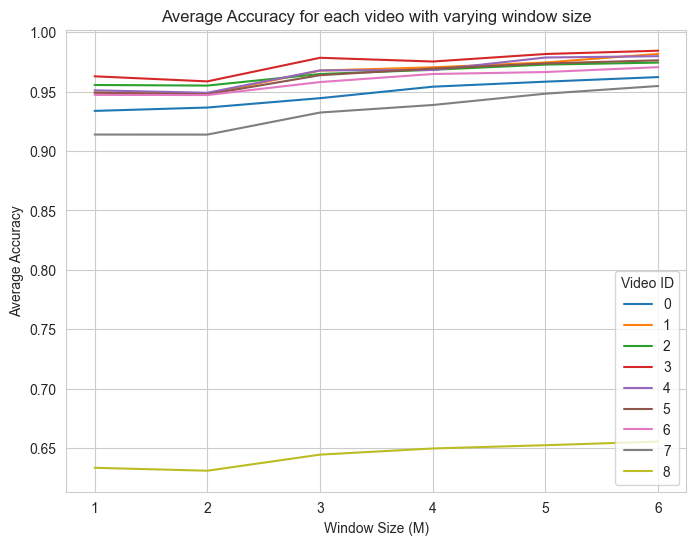

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
import seaborn as sns
from keras.utils import to_categorical
sns.set_style("whitegrid")

def majority_vote(predictions, window_size):
    vote_results = []
    for i in range(0, len(predictions) - window_size + 1, window_size):
        votes = predictions[i:i+window_size]
        vote_result = np.argmax(np.bincount(votes))
        vote_results.append(vote_result)
    return vote_results

def compute_accuracy_with_window(model, data_with_labels, label_map, window_sizes):
    acc_results = []

    for video_id in range(9):
        for window_size in window_sizes:
            accuracy_per_window = []
            for user_id in range(1, 49):
                # 从原始数据中筛选出user_id对应的测试集和video_id的数据
                test_data = data_with_labels[(data_with_labels['user_id'] == user_id) & (data_with_labels['video_id'] == video_id)]

                if test_data.empty:
                    continue

                # 处理数据并获取对应的标签
                train_data, train_labels, test_data, test_labels = process_data(test_data, video_id)
                int_test_labels = np.array([label_map[label] for label in test_labels])
                one_hot_test_labels = to_categorical(int_test_labels, num_classes=len(label_map))

                # 重塑测试数据
                test_data = test_data.reshape(test_data.shape[0], 10, 7)

                # 获取模型预测
                predictions = model.predict(test_data)
                predictions = np.argmax(predictions, axis=1)

                # 应用滑动窗口和多数投票
                vote_results = majority_vote(predictions, window_size)

                # 计算滑动窗口和多数投票后的准确率
                correct = np.sum(vote_results == int_test_labels[:len(vote_results)])
                accuracy = correct / len(vote_results)
                accuracy_per_window.append(accuracy)

            # 计算当前窗口大小下所有用户的平均准确率
            acc_results.append((video_id, window_size, np.mean(accuracy_per_window)))
            print('Video ID: %d, Window size: %d, average accuracy: %.2f' % (video_id, window_size, np.mean(accuracy_per_window)))

    return acc_results

# 设置窗口大小范围
window_sizes = list(range(1, 7, 1))

# 计算各个窗口大小下的准确率
accuracy_results = compute_accuracy_with_window(model, data_with_labels, label_map, window_sizes)

# 转换成pandas DataFrame格式以便绘图
accuracy_df = pd.DataFrame(accuracy_results, columns=['video_id', 'window_size', 'accuracy'])

# 绘制折线图
plt.figure(figsize=(8, 6))
sns.lineplot(data=accuracy_df, x='window_size', y='accuracy', hue='video_id', palette='tab10')
plt.xlabel('Window Size (M)')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for each video with varying window size')
plt.xticks(window_sizes)
plt.grid(True)
plt.legend(title='Video ID', loc='lower right')
plt.show()


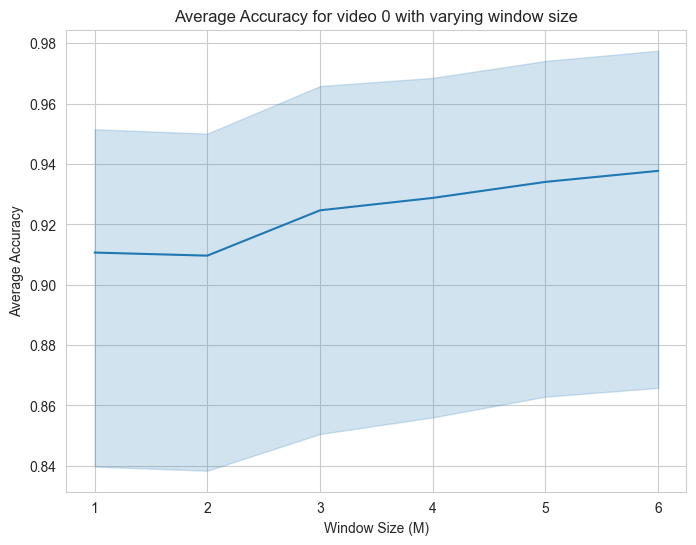

In [9]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=accuracy_df, x='window_size', y='accuracy')
plt.xlabel('Window Size (M)')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for video 0 with varying window size')
plt.xticks(window_sizes)
plt.grid(True)
plt.show()


Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 0, accuracy: 0.86
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 1, accuracy: 0.88
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 2, accuracy: 0.98
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 4, accuracy: 0.86
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 5, accuracy: 0.99
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 6, accuracy: 0.91
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 7, accuracy: 0.98
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 8, accuracy: 0.67
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 0, accuracy: 0.98
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 1, accuracy: 0.98
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 4, accuracy: 0.88
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 5, accuracy: 0.98
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 6, accuracy: 0.95
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 7, accuracy: 0.93
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 8, accuracy: 0.31
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 3, accuracy: 1.00
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 5, accuracy: 0.99
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 6, accuracy: 0.88
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 7, accuracy: 0.73
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 8, accuracy: 0.09
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 1, accuracy: 0.99
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 3, accuracy: 0.91
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 4, accuracy: 0.96
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 5, accuracy: 0.98
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 6, accuracy: 0.93
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 7, accuracy: 0.94
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 8, accuracy: 0.96
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 0, accuracy: 0.98
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 1, accuracy: 0.98
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 2, accuracy: 0.99
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 3, accuracy: 1.00
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 5, accuracy: 0.99
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 6, accuracy: 0.91
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 7, accuracy: 0.99
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 8, accuracy: 0.73
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 0, accuracy: 0.91
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 1, accuracy: 0.98
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 2, accuracy: 0.99
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 3, accuracy: 1.00
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 5, accuracy: 0.98
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 6, accuracy: 0.98
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 7, accuracy: 1.00
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 8, accuracy: 0.76
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 0, accuracy: 0.90
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 1, accuracy: 0.91
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 2, accuracy: 0.95
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 3, accuracy: 0.96
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 4, accuracy: 0.94
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 5, accuracy: 0.98
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 6, accuracy: 0.96
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 7, accuracy: 0.93
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 8, accuracy: 0.76
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 0, accuracy: 0.88
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 1, accuracy: 0.94
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 2, accuracy: 0.47
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 3, accuracy: 0.78
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 4, accuracy: 0.77
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 5, accuracy: 0.74
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 6, accuracy: 0.86
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 7, accuracy: 0.81
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 8, accuracy: 0.61
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 1, accuracy: 0.90
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 2, accuracy: 0.91
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 3, accuracy: 0.97
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 4, accuracy: 0.93
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 5, accuracy: 0.97
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 6, accuracy: 0.99
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 7, accuracy: 0.99
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 8, accuracy: 0.87
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 2, accuracy: 0.99
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 5, accuracy: 0.96
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 6, accuracy: 0.95
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 7, accuracy: 0.98
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 8, accuracy: 0.87
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 0, accuracy: 0.98
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 1, accuracy: 0.98
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 4, accuracy: 0.99
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 5, accuracy: 0.97
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 6, accuracy: 0.94
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 7, accuracy: 0.90
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 8, accuracy: 0.97
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 0, accuracy: 0.93
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 1, accuracy: 0.94
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 2, accuracy: 0.94
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 4, accuracy: 0.92
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 5, accuracy: 0.92
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 6, accuracy: 0.98
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 7, accuracy: 0.94
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 8, accuracy: 0.28
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 0, accuracy: 0.80
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 1, accuracy: 0.85
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 2, accuracy: 0.79
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 3, accuracy: 0.90
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 4, accuracy: 0.91
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 5, accuracy: 0.90
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 6, accuracy: 0.82
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 7, accuracy: 0.69
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 8, accuracy: 0.35
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 0, accuracy: 0.90
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 1, accuracy: 0.97
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 2, accuracy: 0.93
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 3, accuracy: 0.91
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 4, accuracy: 0.87
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 5, accuracy: 0.76
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 6, accuracy: 0.94
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 7, accuracy: 0.83
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 8, accuracy: 0.57
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 0, accuracy: 0.85
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 1, accuracy: 0.94
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 2, accuracy: 0.98
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 3, accuracy: 0.97
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 5, accuracy: 0.99
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 6, accuracy: 0.99
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 7, accuracy: 0.88
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 8, accuracy: 0.29
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 0, accuracy: 0.88
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 1, accuracy: 0.96
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 2, accuracy: 0.92
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 3, accuracy: 0.94
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 4, accuracy: 0.95
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 5, accuracy: 0.96
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 6, accuracy: 1.00
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 7, accuracy: 0.99
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 8, accuracy: 0.72
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 0, accuracy: 0.61
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 1, accuracy: 0.81
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 2, accuracy: 0.97
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 3, accuracy: 0.96
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 4, accuracy: 0.94
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 5, accuracy: 0.97
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 6, accuracy: 0.97
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 7, accuracy: 0.94
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 8, accuracy: 0.66
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 4, accuracy: 0.99
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 5, accuracy: 0.99
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 6, accuracy: 0.99
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 7, accuracy: 0.99
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 8, accuracy: 0.66
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 2, accuracy: 0.99
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 4, accuracy: 0.99
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 5, accuracy: 1.00
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 6, accuracy: 0.99
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 7, accuracy: 0.95
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 8, accuracy: 0.43
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 1, accuracy: 0.98
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 4, accuracy: 0.95
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 5, accuracy: 0.96
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 6, accuracy: 1.00
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 7, accuracy: 1.00
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 8, accuracy: 1.00
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 0, accuracy: 0.99
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 1, accuracy: 0.96
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 2, accuracy: 0.98
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 3, accuracy: 0.98
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 4, accuracy: 0.98
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 5, accuracy: 0.97
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 6, accuracy: 0.94
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 7, accuracy: 0.98
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 8, accuracy: 0.26
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 0, accuracy: 0.98
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 1, accuracy: 0.99
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 2, accuracy: 0.93
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 3, accuracy: 0.96
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 4, accuracy: 0.97
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 5, accuracy: 0.97
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 6, accuracy: 0.91
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 7, accuracy: 0.63
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 8, accuracy: 0.07
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 0, accuracy: 0.97
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 1, accuracy: 0.99
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 2, accuracy: 0.99
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 4, accuracy: 0.79
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 5, accuracy: 0.98
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 6, accuracy: 0.99
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 7, accuracy: 0.97
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 8, accuracy: 0.95
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 0, accuracy: 0.81
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 1, accuracy: 0.74
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 3, accuracy: 0.91
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 4, accuracy: 0.94
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 5, accuracy: 0.85
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 6, accuracy: 0.94
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 7, accuracy: 0.68
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 8, accuracy: 0.23
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 0, accuracy: 0.96
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 1, accuracy: 0.99
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 2, accuracy: 0.98
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 3, accuracy: 0.98
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 4, accuracy: 0.97
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 5, accuracy: 0.96
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 6, accuracy: 0.99
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 7, accuracy: 0.96
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 8, accuracy: 0.91
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 0, accuracy: 0.90
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 2, accuracy: 0.97
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 3, accuracy: 0.98
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 4, accuracy: 0.97
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 5, accuracy: 0.99
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 6, accuracy: 0.95
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 7, accuracy: 0.92
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 8, accuracy: 0.70
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 1, accuracy: 0.97
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 2, accuracy: 0.98
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 3, accuracy: 1.00
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 4, accuracy: 0.96
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 5, accuracy: 0.99
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 6, accuracy: 0.99
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 7, accuracy: 1.00
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 8, accuracy: 0.02
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 0, accuracy: 0.94
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 1, accuracy: 0.94
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 2, accuracy: 0.97
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 3, accuracy: 1.00
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 4, accuracy: 0.99
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 5, accuracy: 0.98
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 6, accuracy: 1.00
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 7, accuracy: 1.00
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 8, accuracy: 0.97
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 3, accuracy: 1.00
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 5, accuracy: 1.00
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 6, accuracy: 1.00
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 7, accuracy: 1.00
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 8, accuracy: 1.00
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 2, accuracy: 0.99
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 3, accuracy: 1.00
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 5, accuracy: 0.99
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 6, accuracy: 0.88
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 7, accuracy: 0.63
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 8, accuracy: 0.26
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 0, accuracy: 0.98
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 1, accuracy: 0.97
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 2, accuracy: 0.99
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 4, accuracy: 0.98
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 5, accuracy: 0.98
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 6, accuracy: 0.99
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 7, accuracy: 0.99
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 8, accuracy: 0.97
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 0, accuracy: 0.99
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 1, accuracy: 0.91
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 2, accuracy: 0.97
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 5, accuracy: 1.00
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 6, accuracy: 1.00
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 7, accuracy: 1.00
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 8, accuracy: 1.00
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 0, accuracy: 0.99
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 1, accuracy: 0.97
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 2, accuracy: 0.97
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 3, accuracy: 1.00
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 4, accuracy: 0.93
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 5, accuracy: 0.98
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 6, accuracy: 0.97
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 7, accuracy: 1.00
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 8, accuracy: 0.93
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 0, accuracy: 0.91
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 1, accuracy: 0.92
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 5, accuracy: 1.00
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 6, accuracy: 1.00
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 7, accuracy: 0.99
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 8, accuracy: 0.97
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 0, accuracy: 0.99
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 1, accuracy: 0.96
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 2, accuracy: 0.95
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 4, accuracy: 0.97
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 5, accuracy: 0.90
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 6, accuracy: 0.97
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 7, accuracy: 0.99
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 8, accuracy: 0.84
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 0, accuracy: 0.82
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 1, accuracy: 0.96
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 2, accuracy: 0.95
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 3, accuracy: 0.91
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 4, accuracy: 0.94
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 5, accuracy: 0.82
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 6, accuracy: 0.73
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 7, accuracy: 0.86
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 8, accuracy: 0.37
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 0, accuracy: 0.85
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 1, accuracy: 0.91
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 2, accuracy: 0.89
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 3, accuracy: 0.83
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 4, accuracy: 0.84
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 5, accuracy: 0.89
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 6, accuracy: 0.90
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 7, accuracy: 0.74
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 8, accuracy: 0.15
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 0, accuracy: 0.87
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 1, accuracy: 0.92
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 2, accuracy: 0.95
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 3, accuracy: 0.85
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 4, accuracy: 0.96
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 5, accuracy: 0.85
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 6, accuracy: 0.96
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 7, accuracy: 0.80
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 8, accuracy: 0.66
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 0, accuracy: 0.94
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 2, accuracy: 0.96
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 3, accuracy: 0.94
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 4, accuracy: 0.91
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 5, accuracy: 0.95
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 6, accuracy: 0.98
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 7, accuracy: 0.99
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 8, accuracy: 0.51
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 1, accuracy: 0.99
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 4, accuracy: 0.99
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 5, accuracy: 0.99
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 6, accuracy: 0.99
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 7, accuracy: 0.91
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 8, accuracy: 0.77
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 0, accuracy: 0.86
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 1, accuracy: 0.86
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 2, accuracy: 0.94
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 4, accuracy: 0.99
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 5, accuracy: 0.97
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 6, accuracy: 0.98
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 7, accuracy: 0.99
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 8, accuracy: 0.68
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 0, accuracy: 0.99
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 2, accuracy: 0.99
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 4, accuracy: 0.99
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 5, accuracy: 0.91
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 6, accuracy: 0.91
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 7, accuracy: 0.94
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 8, accuracy: 0.67
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 0, accuracy: 0.75
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 1, accuracy: 0.76
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 2, accuracy: 0.85
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 3, accuracy: 0.84
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 4, accuracy: 0.90
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 5, accuracy: 0.72
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 6, accuracy: 0.67
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 7, accuracy: 0.79
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 8, accuracy: 0.05
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 3, accuracy: 1.00
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 5, accuracy: 1.00
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 6, accuracy: 1.00
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 7, accuracy: 1.00
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 8, accuracy: 1.00
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 0, accuracy: 0.99
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 2, accuracy: 1.00
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 3, accuracy: 0.99
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 5, accuracy: 1.00
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 6, accuracy: 1.00
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 7, accuracy: 0.99
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 8, accuracy: 0.99
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 0, accuracy: 0.99
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 1, accuracy: 0.96
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 2, accuracy: 0.98
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 3, accuracy: 0.95
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 4, accuracy: 0.96
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 5, accuracy: 1.00
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 6, accuracy: 1.00
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 7, accuracy: 0.95
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 8, accuracy: 0.82
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 0, accuracy: 0.89
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 1, accuracy: 0.95
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 2, accuracy: 0.91
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 3, accuracy: 0.97
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 4, accuracy: 0.91
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 5, accuracy: 0.98
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 6, accuracy: 0.91
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 7, accuracy: 0.88
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 8, accuracy: 0.62
Processing 0


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 0, accuracy: 1.00
Processing 1


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 1, accuracy: 1.00
Processing 2


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 2, accuracy: 0.99
Processing 3


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 3, accuracy: 0.97
Processing 4


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 4, accuracy: 1.00
Processing 5


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 5, accuracy: 0.96
Processing 6


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 6, accuracy: 0.98
Processing 7


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 7, accuracy: 0.89
Processing 8


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 8, accuracy: 0.53


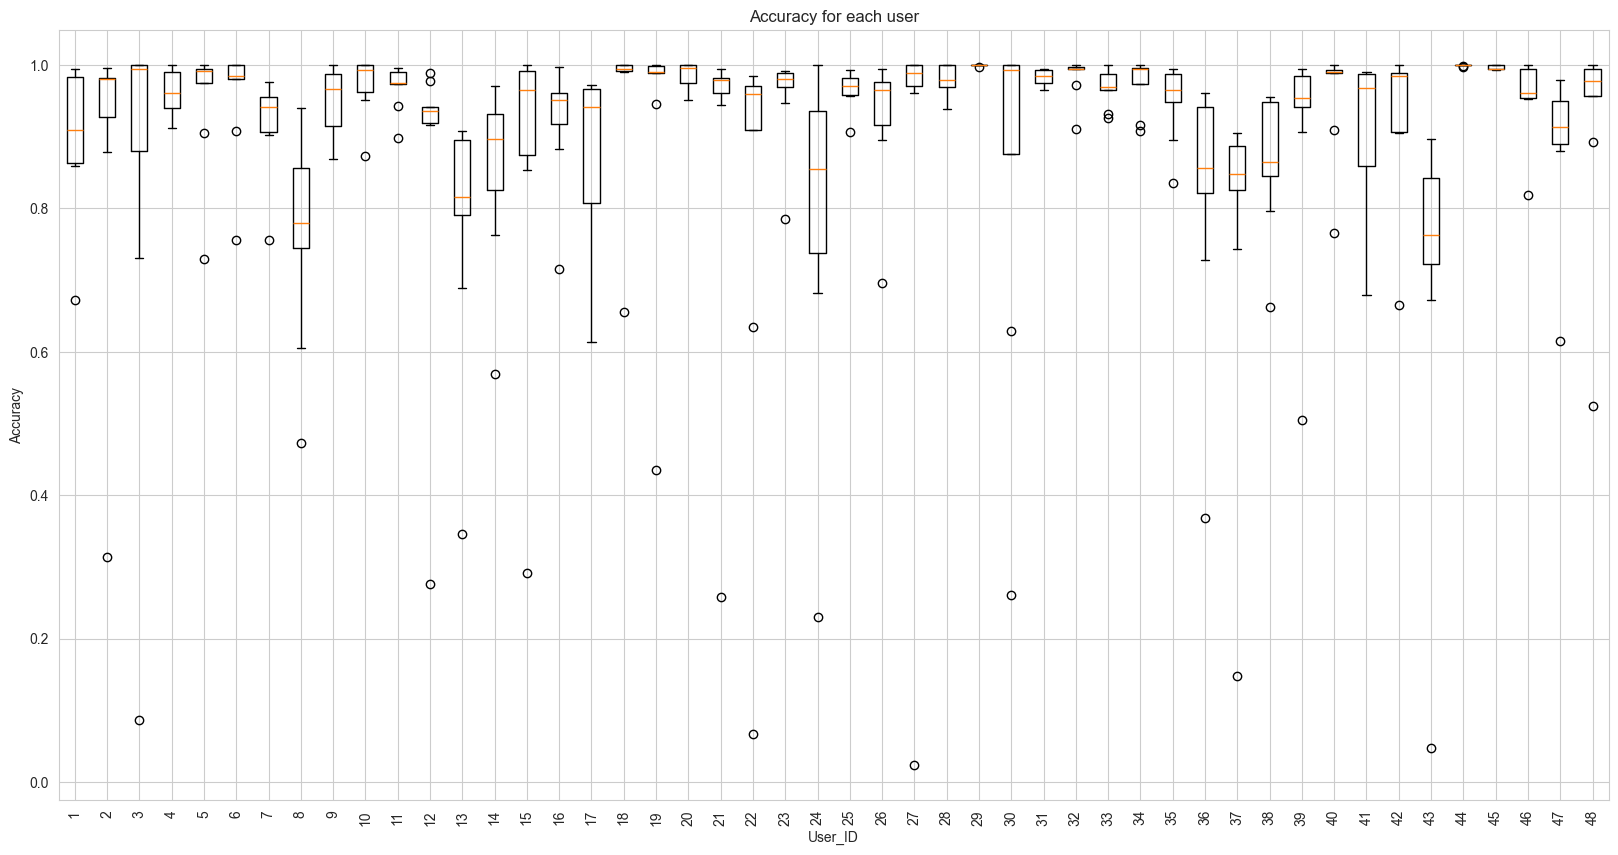

In [10]:
def compute_accuracy_per_user(model, data_with_labels, unique_labels, label_map):
    user_acc_results = {}

    for user_id in range(1, 49): # assume user_id from 1 to 48
        acc_results = []

        for video_id in range(0, 9):
            # 从原始数据中筛选出video_id和user_id对应的测试集
            test_data = data_with_labels[(data_with_labels['video_id'] == video_id) & (data_with_labels['user_id'] == user_id)]

            # 如果测试数据为空，跳过此轮循环
            if test_data.empty:
                continue

            # 处理数据并获取对应的标签
            train_data, train_labels, test_data, test_labels = process_data(test_data, video_id)
            int_test_labels = np.array([label_map[label] for label in test_labels])
            one_hot_test_labels = to_categorical(int_test_labels, num_classes=len(unique_labels))

            # 重塑测试数据
            test_data = test_data.reshape(test_data.shape[0], 10, 7)

            try:
                # 计算准确率
                loss, accuracy = model.evaluate(test_data, one_hot_test_labels, batch_size=len(test_data), verbose=0)
            except ValueError as e:
                print(f"Skipping evaluation for user_id: {user_id}, video_id: {video_id}. Evaluation returned: {e}")
                continue

            acc_results.append(accuracy)
            print('user_id: %d, video_id: %d, accuracy: %.2f' % (user_id, video_id, accuracy))

        # 若对于某个用户没有任何准确度数据（可能该用户没有对应的数据），则不添加到最终的结果中
        if acc_results:
            user_acc_results[user_id] = acc_results

    return user_acc_results

# 计算各个测试集的准确率
user_accuracy_results = compute_accuracy_per_user(model, data_with_labels, unique_labels, label_map)

# 创建箱形图
plt.figure(figsize=(20, 10)) # You might need to adjust the figure size
plt.boxplot([user_accuracy_results[user_id] for user_id in sorted(user_accuracy_results.keys())], labels=sorted(user_accuracy_results.keys()))
plt.xlabel('User_ID')
plt.ylabel('Accuracy')
plt.title('Accuracy for each user')
plt.xticks(rotation=90)  # It might be necessary to rotate the x-tick labels for better visualization
plt.show()


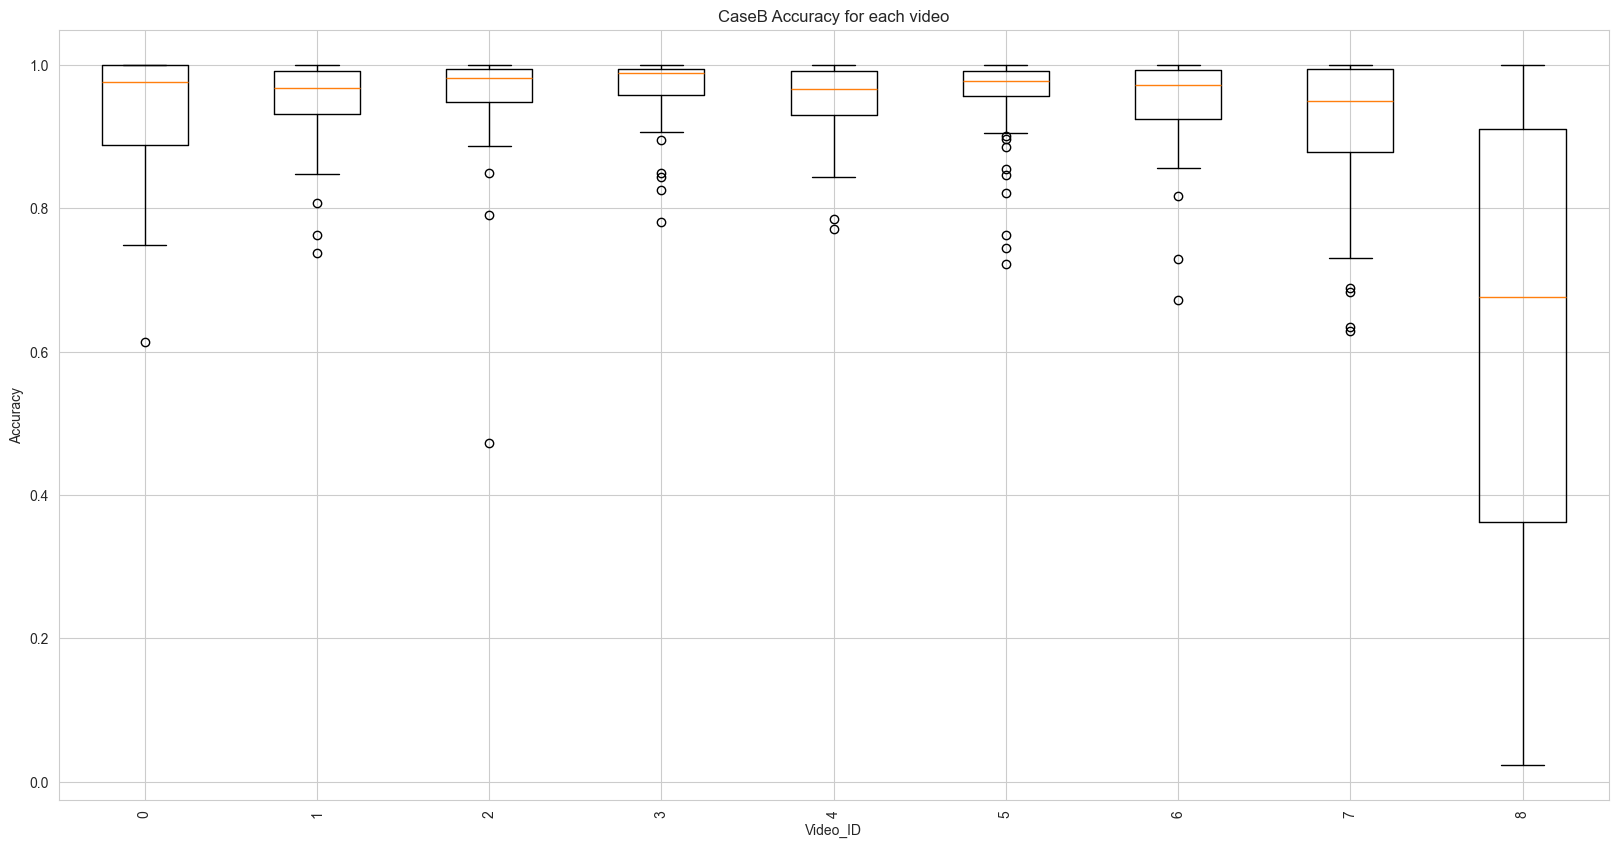

In [11]:
def reorganize_accuracy_by_video(user_accuracy_results):
    video_acc_results = {i: [] for i in range(0, 9)}
    for user_id, acc_list in user_accuracy_results.items():
        for video_id, accuracy in enumerate(acc_list):
            video_acc_results[video_id].append(accuracy)
    return video_acc_results

video_accuracy_results = reorganize_accuracy_by_video(user_accuracy_results)

plt.figure(figsize=(20, 10)) # You might need to adjust the figure size
plt.boxplot([video_accuracy_results[video_id] for video_id in sorted(video_accuracy_results.keys())], labels=sorted(video_accuracy_results.keys()))
plt.xlabel('Video_ID')
plt.ylabel('Accuracy')
plt.title('CaseB Accuracy for each video')
plt.xticks(rotation=90)  # It might be necessary to rotate the x-tick labels for better visualization
plt.show()


In [31]:
plt.close('all')